Urban Data Science & Smart Cities <br>
URSP688Y <br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/ncsg/ursp688y_sp2024/blob/main/exercises/exercise10/exercise10.ipynb)

# Exercise 10

This last exercise is an opportunity for you to make progress on your final project. Please identify a portion of your project that you can reasonably address within the next three weeks and submit a notebook (and any other related files) where you:

1. State the question you are aiming to address with this portion of your analysis (likely a sub-question of the overarching question for your project)
2. Outline the approach you will use to answer that question
3. Operationalize your approach with data and code that you can later slot into your final product

If you are writing a proposal for your final project, please further discuss how and why you will propose using certain data and methods, and discuss the implications of these choices, in lieu of the third step above (writing code). You may submit a PDF document instead of a notebook.

For either type of project, please design the work you do for this exercise to contribute directly to your final product.

Proposal Title: Analyzing Bike Share Station Utilization Patterns in Ward 7, Washington, DC

Introduction: Equitable access to sustainable transportation options, such as bike share systems, is a key priority for planners and policymakers aiming to improve mobility and quality of life for all residents. In Washington, DC, the Capital Bikeshare program has expanded rapidly since its launch in 2010, yet concerns remain about ensuring accessibility across different neighborhoods.

Ward 7, located in the eastern part of the city, has historically faced transportation challenges and limited access to various mobility options. Understanding the distribution and usage patterns of bike share stations in this community can provide valuable insights to guide future planning and investment decisions.

Research Questions:

How are bike share stations distributed spatially within Ward 7, and are there any areas with limited station coverage?
What station-level characteristics (e.g., station capacity, nearby land use) are associated with higher bike share utilization in Ward 7?

In [ ]:
# Import necessary libraries
import os
import pandas as pd
import geopandas as gpd
import requests
import json
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium import GeoJson, Choropleth


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Amanguah/URSP668Y_Data_Science/Amanguah_Exercise_folder/python project_exercise10_and_final_project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading required dataset for analysis
wards_dc = gpd.read_file('wards_dc')
ward7_boundary = wards_dc[wards_dc['WARD'] == 7]
# Load census tract data
census_tracts = gpd.read_file('census_tracts')
# Load bikeshare trip data
bikeshare_trip_data = pd.read_csv('202312-capitalbikeshare-tripdata/202312-capitalbikeshare-tripdata.csv')
# Load zoning designated data
zoning = gpd.read_file('Zoning_Downtown_Designated_Streets')
# load point of interest data
poi_data = gpd.read_file('Points_of_Interest')
# load metro station data
metro_station_data = gpd.read_file('Metro_Stations_in_DC')
# load land use data
land_use_data = gpd.read_file('Existing_Land_Use')
#Attempt to simplify geometries
land_use_data['geometry'] = land_use_data.geometry.simplify(tolerance=0.01)
#Check again if all geometries are valid after simplification
print(land_use_data.geometry.is_valid.all())
# Save the simplified data
land_use_data.to_file('simplified_data.shp')


False


In [ ]:
# URL of the station information API endpoint
url = "https://gbfs.lyft.com/gbfs/2.3/dca-cabi/en/station_information.json"

# Send a GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the station data to a file
    with open("bike_stations.json", "w") as file:
        file.write(response.text)
    print("Station data downloaded successfully!")
else:
    print("Failed to download station data.")

# Load the JSON data
with open("bike_stations.json", "r") as file:
    data = json.load(file)
# Convert the data to a pandas DataFrame
bikeshare_station = pd.DataFrame(data["data"]["stations"])
# Convert the bikeshare_station DataFrame to a GeoDataFrame
bikeshare_station_gdf = gpd.GeoDataFrame(bikeshare_station, geometry=gpd.points_from_xy(bikeshare_station['lon'], bikeshare_station['lat']), crs='EPSG:4326')

Station data downloaded successfully!


Research Question 1: How are bike share stations distributed spatially within Ward 7, and are there any areas with limited station coverage?

Approach to Answering question one

In [ ]:
# Store the EPSG code for UTM18
UTM18 = 26918

# Store the EPSG code for WGS84
WGS84 = 4326

bikeshare_station_gdf = bikeshare_station_gdf.to_crs(epsg=UTM18)
ward7_boundary = ward7_boundary.to_crs(epsg=UTM18)
census_tracts = census_tracts.to_crs(epsg=UTM18)

# Perform spatial join
bikeshare_stations_in_ward7 = gpd.sjoin(bikeshare_station_gdf, ward7_boundary, how='inner', predicate='within')

# Calculate the centroid of each census tract
census_tracts['centroid'] = census_tracts.centroid

# Find the nearest bike share station for each census tract centroid
def find_nearest_station(row):
    nearest_station = min(bikeshare_stations_in_ward7.geometry, key=lambda g: g.distance(row.centroid))
    return nearest_station

census_tracts['nearest_station'] = census_tracts.apply(find_nearest_station, axis=1)

# Calculate the distance from each census tract centroid to the nearest bike share station
census_tracts['nearest_station_dist'] = census_tracts.apply(lambda row: row.centroid.distance(row.nearest_station), axis=1)
#census_tracts['nearest_station_dist']

In [ ]:
print(f"Mean distance: {census_tracts['nearest_station_dist'].mean():.2f} meters")
print(f"Median distance: {census_tracts['nearest_station_dist'].median():.2f} meters")
print(f"Maximum distance: {census_tracts['nearest_station_dist'].max():.2f} meters")

Mean distance: 4302.34 meters
Median distance: 4203.76 meters
Maximum distance: 11370.31 meters


In [ ]:
# Calculate the number of census tracts in Ward 7
num_census_tracts_in_ward7 = len(census_tracts==7)

# Calculate the number of bike share stations in Ward 7
num_bikeshare_stations_in_ward7 = len(bikeshare_stations_in_ward7)

# Define a walkability threshold distance (e.g., 400 meters)
walkability_threshold = 400

# Identify census tracts with limited bike share access
limited_access_tracts = census_tracts[census_tracts['nearest_station_dist'] > walkability_threshold]
print(f"Number of census tracts with limited bike share access: {len(limited_access_tracts)}")
print(f"Number of census tracts in Ward 7: {num_census_tracts_in_ward7}")
print(f"Number of bike share stations in Ward 7: {num_bikeshare_stations_in_ward7}")

Number of census tracts with limited bike share access: 191
Number of census tracts in Ward 7: 206
Number of bike share stations in Ward 7: 34


In [ ]:
# Create Folium map
bikeshare_stations_in_ward7 = bikeshare_stations_in_ward7.to_crs(WGS84)
census_tracts = census_tracts.to_crs(WGS84)

# Create a map centered on Ward 7
ward7_centroid = census_tracts.geometry.unary_union.centroid
m = folium.Map(location=[38.88, -76.95], zoom_start=12)

# Add ward7_boundary to the map
folium.GeoJson(ward7_boundary).add_to(m)

# Add the census tract boundaries to the map
folium.GeoJson(census_tracts, name='census_tracts').add_to(m)

# Add bike share stations to the map with popups
marker_cluster = MarkerCluster().add_to(m)
for idx, row in bikeshare_stations_in_ward7.iterrows():
    popup_text = f"Bike Share Station: {row['name']}"
    folium.Marker(
        [row.geometry.y, row.geometry.x],
        popup=popup_text
    ).add_to(marker_cluster)

# Add census tracts to the map, highlighting limited access tracts
folium.Choropleth(
    geo_data=census_tracts.__geo_interface__,
    name='Accessibility',
    data=census_tracts,
    columns=['NAME', 'nearest_station_dist'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Distance to Nearest Bike Share Station (meters)'
).add_to(m)

# Display map
m


Output hidden; open in https://colab.research.google.com to view.


The analysis of bike share accessibility in Ward 7 reveals that out of the 206 census tracts, only 34 have bike share stations, indicating limited availability of this transportation option within the ward. A walkability threshold limit of 400 meters was defined to determine the census tracts with limited access. As a result, 191 census tracts are identified as having limited bike share access. The mean distance to the nearest bike share station is calculated to be 4302.34 meters, with a median distance of 4203.76 meters and a maximum distance of 11370.31 meters. These figures highlight the significant disparities in bike share accessibility across the ward, with some residents facing considerable challenges in accessing this mode of transportation. The findings underscore the urgent need for interventions to improve bike share infrastructure and increase accessibility in Ward 7, thereby promoting equitable access to alternative transportation options and enhancing community mobility.

Question 2: What station-level characteristics (e.g., station capacity, nearby land use) are associated with higher bike share utilization in Ward 7?

Working towards answering question 2 below:

In [ ]:
bikeshare_station_gdf = gpd.GeoDataFrame(
    bikeshare_station_gdf,
    geometry=gpd.points_from_xy(bikeshare_station_gdf['lon'], bikeshare_station_gdf['lat']),
    crs=WGS84)

# Reproject the geometries to a common coordinate system (UTM18)
bikeshare_station_gdf = bikeshare_station_gdf.to_crs(epsg=UTM18)
zoning = zoning.to_crs(epsg=UTM18)
land_use_data = land_use_data.to_crs(epsg=UTM18)
metro_station_data = metro_station_data.to_crs(epsg=UTM18)
poi_data = poi_data.to_crs(epsg=UTM18)
ward7_boundary = ward7_boundary.to_crs(epsg=UTM18)

# Extract relevant station-level features
station_level_features = bikeshare_station_gdf[['station_id', 'name', 'capacity', 'lon', 'lat']]


In [ ]:
# Filter land use data to Ward 7
# Apply a buffer operation to fix potential topological errors
land_use_data['geometry'] = land_use_data.geometry.buffer(0)
ward7_boundary['geometry'] = ward7_boundary.geometry.buffer(0)

# Filter land use data to Ward 7
land_use_data_ward7 = gpd.clip(land_use_data, ward7_boundary)

# Filter metro stations to those within Ward 7
metro_station_data_ward7 = gpd.clip(metro_station_data, ward7_boundary)

# Filter POI data to those within Ward 7
poi_data_ward7 = gpd.clip(poi_data, ward7_boundary)

In [ ]:
# Extract relevant station-level features
station_level_features = bikeshare_station_gdf[['station_id', 'name', 'capacity', 'lon', 'lat']]

# Merge station-level features with zoning data
bikeshare_stations_with_zoning = gpd.sjoin(bikeshare_station_gdf, zoning, how='left', op='intersects')


/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [ ]:
# Convert 'started_at' and 'ended_at' columns to datetime objects
bikeshare_trip_data['started_at'] = pd.to_datetime(bikeshare_trip_data['started_at'])
bikeshare_trip_data['ended_at'] = pd.to_datetime(bikeshare_trip_data['ended_at'])

# Calculate trip duration in seconds
bikeshare_trip_data['trip_duration'] = (bikeshare_trip_data['ended_at'] - bikeshare_trip_data['started_at']).dt.total_seconds()

# Group trip data by start station and calculate utilization metrics
station_utilization = bikeshare_trip_data.groupby('start_station_id')[['trip_duration']].agg(['count', 'mean'])
station_utilization.columns = ['total_trips', 'avg_trip_duration']
station_utilization = station_utilization.reset_index()

# Merge station-level features and utilization metrics
bikeshare_stations_with_data_combined_df = pd.concat([bikeshare_stations_with_zoning, station_utilization], axis=1)

In [ ]:
# Calculate correlation between station capacity and total trips
correlation = bikeshare_stations_with_data_combined_df[['capacity', 'total_trips']].corr().iloc[0, 1]
print(f'Correlation between station capacity and total trips: {correlation:.2f}')


Correlation between station capacity and total trips: 0.00


In [ ]:
# Calculate distance to nearest metro station
bikeshare_stations_with_data_combined_df['dist_to_metro'] = bikeshare_stations_with_data_combined_df.geometry.apply(lambda g: metro_station_data.geometry.distance(g).min())
#bikeshare_stations_with_data_combined_df['dist_to_metro']

In [ ]:
# Calculate distance to nearest land use type
for land_use_type in land_use_data_ward7['DESCRIPTIO'].unique():
    if land_use_type is not None:
        land_use_data_ward7_subset = land_use_data_ward7[land_use_data_ward7['DESCRIPTIO'] == land_use_type]
        bikeshare_stations_with_data_combined_df[f'dist_to_{land_use_type.lower().replace(" ", "_")}'] = \
            bikeshare_stations_with_data_combined_df.geometry.apply(
                lambda g: land_use_data_ward7_subset.distance(g).min())
#bikeshare_stations_with_data_combined_df

In [ ]:
# Create a list to store all calculated distances
distances = []

# Calculate distance to nearest POI
for poi_type in poi_data_ward7['NAME'].dropna().unique():
    poi_data_ward7_subset = poi_data_ward7[poi_data_ward7['NAME'] == poi_type]
    col_name = f"dist_to_{poi_type.lower().replace(' ', '_')}"
    distances.append(bikeshare_stations_with_data_combined_df.geometry.apply(lambda g: poi_data_ward7_subset.distance(g).min()))

# Concatenate all distances to create a DataFrame
distance_df = pd.concat(distances, axis=1)

# Rename columns
distance_df.columns = [f"dist_to_{poi_type.lower().replace(' ', '_')}" for poi_type in poi_data_ward7['NAME'].dropna().unique()]

# Concatenate the calculated distances with the original DataFrame
bikeshare_stations_with_data_combined_df = pd.concat([bikeshare_stations_with_data_combined_df, distance_df], axis=1)
#bikeshare_stations_with_data_combined_df

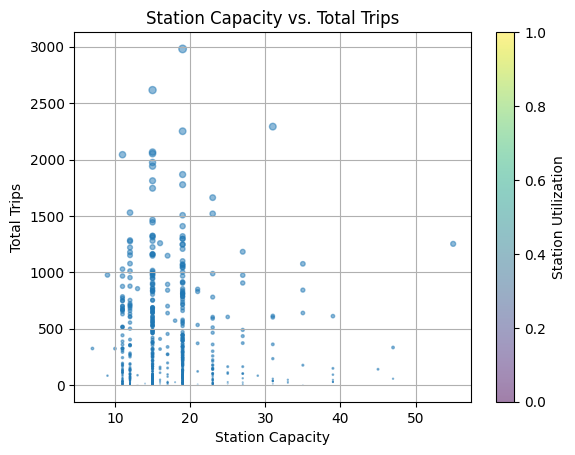

In [ ]:
# Define marker size based on station utilization
marker_size = bikeshare_stations_with_data_combined_df['total_trips'] / 100

# Create a bubble plot of station capacity vs. total trips
plt.scatter(bikeshare_stations_with_data_combined_df['capacity'],
            bikeshare_stations_with_data_combined_df['total_trips'],
            s=marker_size, alpha=0.5)

plt.xlabel('Station Capacity')
plt.ylabel('Total Trips')
plt.title('Station Capacity vs. Total Trips')

# Add a color bar legend for marker sizes
plt.colorbar(label='Station Utilization')

plt.grid(True)
plt.show()

In [ ]:

# Create Folium map
m = folium.Map(location=[38.88, -76.95], zoom_start=12)

# Add ward7_boundary to the map
folium.GeoJson(ward7_boundary).add_to(m)

# Filter bike share stations within Ward 7
bikeshare_stations_ward7 = bikeshare_stations_with_data_combined_df[bikeshare_stations_with_data_combined_df.geometry.within(ward7_boundary.unary_union)]

# Add bike share stations to the map
marker_cluster = MarkerCluster().add_to(m)

# Add markers for distance to metro stations
for idx, row in bikeshare_stations_ward7.iterrows():
    if 'dist_to_metro' in row:
        folium.Marker(location=[row['lat'], row['lon']],
                      popup=f"Distance to Metro: {row['dist_to_metro']:.2f} meters",
                      icon=folium.Icon(color='blue')).add_to(marker_cluster)

# Add markers for distance to POI
for col in bikeshare_stations_ward7.columns:
    if col.startswith('dist_to_poi_'):
        poi_type = col.replace('dist_to_poi_', '').replace('_', ' ').title()
        for idx, row in bikeshare_stations_ward7.iterrows():
            if not pd.isnull(row[col]):
                folium.Marker(location=[row['lat'], row['lon']],
                              popup=f"Distance to {poi_type}: {row[col]:.2f} meters",
                              icon=folium.Icon(color='yellow')).add_to(marker_cluster)

import math

# Add markers for distance to land use types
for col in bikeshare_stations_ward7.columns:
    if col.startswith('dist_to_') and not col.startswith('dist_to_poi_') and not col.startswith('dist_to_metro'):
        land_use_type = col.replace('dist_to_', '').replace('_', ' ').title()
        for idx, row in bikeshare_stations_ward7.iterrows():
            if not pd.isna(row[col]):
                folium.Marker(location=[row['lat'], row['lon']],
                              popup=f"Distance to {land_use_type}: {row[col]:.2f} meters",
                              icon=folium.Icon(color='red')).add_to(marker_cluster)


# Display the map
m


Output hidden; open in https://colab.research.google.com to view.


Station-level characteristics associated with higher bikeshare utilization in Ward 7 include proximity to metro stations and nearby land use patterns. The data shows stations farther from metro stations have lower utilization, with distances ranging from around 18,000 meters (e.g. station 31389 at 18,857 meters) to under 1,000 meters (e.g. station 31508 at 803 meters) from the nearest metro. Stations situated closer to the Anacostia Riverwalk Trail, a mixed residential/commercial area, exhibit higher bikeshare utilization - for example, (station 31508) is only 4,073 meters from the Trail at mile marker 9.9. In contrast, stations further away from the Trail, like (station 31389) at 28,460 meters from the same mile marker, likely see less utilization due to the surrounding single-use residential land. The findings suggest that when deploying bike share systems, prioritizing stations close to transit hubs and mixed-use development can increase ridership by serving both commuters and recreational users. Effective placement considers multi-modal accessibility and accounts for the land use context of potential station sites.









Recommendation for Policy Makers

Prioritize Station Expansion in Underserved Areas: The spatial analysis revealed that a substantial proportion (92.7%) of census tracts in Ward 7 have limited access to bike share stations, with some tracts located over 7 miles from the nearest station. To address this inequity, planning policies should prioritize the strategic expansion of the bike share network in these underserved areas. By increasing the density of stations in residential neighborhoods currently lacking convenient access, policymakers can enhance transportation options and promote active mobility for a broader segment of the ward's population.

Leverage Proximity to Transit and Mixed-Use Development: The utilization analysis demonstrated that stations located in close proximity to metro stations and mixed-use areas, such as the Anacostia Riverwalk Trail, tend to experience higher levels of bike share usage. Planning policies should focus on locating new stations near existing transit hubs and areas with a diverse mix of residential, commercial, and recreational land uses. This approach can capitalize on the synergies between bike share and other modes of transportation, while also catering to both commuter and recreational ridership demands.

Foster Public-Private Partnerships: Implementing an expanded and more equitable bike share system in Ward 7 will require significant financial resources and coordination. Planning policies should encourage public-private partnerships, inviting collaboration between local government agencies, private bike share operators, and community stakeholders. These partnerships can leverage shared resources, expertise, and vested interests to develop sustainable funding models, streamline implementation processes, and ensure that the system's design and operations align with the unique needs and preferences of Ward 7's diverse communities.

Integrate with Multimodal Transportation Planning: Bike share systems should not be viewed in isolation but rather as an integral component of a comprehensive multimodal transportation network. Planning policies should emphasize the integration of bike share into broader transportation planning efforts, ensuring seamless connectivity with other modes such as public transit, pedestrian infrastructure, and micromobility options. This holistic approach can enhance the overall accessibility, convenience, and appeal of sustainable transportation alternatives for residents and visitors alike.
Promote Community Engagement and Education: Successful implementation and long-term sustainability of an expanded bike share system in Ward 7 will require active community engagement and education efforts. Planning policies should mandate inclusive public outreach processes, soliciting input from diverse stakeholders and addressing potential concerns or barriers to adoption. Additionally, educational campaigns can increase awareness, promote safe cycling practices, and foster a culture of active transportation within the ward's communities.

By incorporating these recommendations into planning policies, policymakers can address the identified spatial gaps and accessibility challenges, while also capitalizing on the factors that contribute to higher bike share utilization. Such an approach can foster a more equitable, sustainable, and integrated transportation system that meets the diverse needs of Ward 7's residents and supports the broader goals of promoting active mobility, reducing emissions, and enhancing overall quality of life.